<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/SwinIR_demo_on_rPPG_compressed_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [2]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media

Python 3.11.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00


In [20]:
# Download SwinIR pretrained models
!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/005_colorDN_DFWB_s128w8_SwinIR-M_noise15.pth -P experiments/pretrained_models

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (119/119), done.
--2025-07-03 02:17:01--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/396770997/2c43e270-4a3e-4893-8920-1dc0550fec2f?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20250703%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250703T021701Z&X-Amz-Expires=1800&X-Amz-Signature=a4ed80f08cf3eb96e218bca2be5487e59952bd6b905

In [4]:
### UBFC-rPPG dataset in drive folder
from google.colab import drive

drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi' # @param {type: "string"}
!ls -l $filepath

Mounted at /content/drive
-r-------- 1 root root 1425830568 Nov 16  2017 /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi


In [6]:
video = media.read_video(filepath)

In [7]:
# Compress the video with default settings (H.264 codec)
COMPRESSION_BIT_RATES = {500_000, 200_000, 100_000}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))

3242186
1303890
658209


In [8]:
# Save the compressed video to a file
with open('/tmp/subject1_500_000.mp4', 'wb') as f:
    f.write(compressed_data[500_000])
with open('/tmp/subject1_200_000.mp4', 'wb') as f:
    f.write(compressed_data[200_000])
with open('/tmp/subject1_100_000.mp4', 'wb') as f:
    f.write(compressed_data[100_000])

In [9]:
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_500_000.mp4')
compressed_video_2 = media.read_video('/tmp/subject1_200_000.mp4')
compressed_video_3 = media.read_video('/tmp/subject1_100_000.mp4')
videos = {'Original': video[:10], 'Compressed_200_000': compressed_video_2[:10], 'Compressed_100_000': compressed_video_3[:10], 'Compressed_500_000': compressed_video[:10] }
media.show_videos(videos, fps=30)

In [10]:
import cv2
import os
import shutil

"""
This script converts a video into individual frames and saves them to a specified directory.
Only a subset of frames is saved based on a defined interval to match the desired frame rate for further processing.
"""

# Path to the video file
video_path = '/tmp/subject1_100_000.mp4' # @param {type: "string"}

# Directory to save the frames
output_folder = '/tmp/output_dir_100' # @param {type: "string"}

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Load the video
cap = cv2.VideoCapture(video_path)

# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
frames_per_second = 10
interval = int(fps / frames_per_second)

frame_count = 0
saved_frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Save frame if it's in the interval
    if frame_count % interval == 0:
        frame_filename = os.path.join(output_folder, f'frame_{saved_frame_count:04d}.jpg')
        # Save the frame as a JPG image
        cv2.imwrite(frame_filename, frame)
        saved_frame_count += 1

    frame_count += 1

cap.release()
print(f'Extracted {saved_frame_count} frames to {output_folder}')

Extracted 516 frames to /tmp/output_dir_100


In [11]:
!ls -l $output_folder

total 27016
-rw-r--r-- 1 root root 41121 Jul  3 02:06 frame_0000.jpg
-rw-r--r-- 1 root root 41131 Jul  3 02:06 frame_0001.jpg
-rw-r--r-- 1 root root 41194 Jul  3 02:06 frame_0002.jpg
-rw-r--r-- 1 root root 41267 Jul  3 02:06 frame_0003.jpg
-rw-r--r-- 1 root root 41426 Jul  3 02:06 frame_0004.jpg
-rw-r--r-- 1 root root 44583 Jul  3 02:06 frame_0005.jpg
-rw-r--r-- 1 root root 45988 Jul  3 02:06 frame_0006.jpg
-rw-r--r-- 1 root root 47873 Jul  3 02:06 frame_0007.jpg
-rw-r--r-- 1 root root 47444 Jul  3 02:06 frame_0008.jpg
-rw-r--r-- 1 root root 48901 Jul  3 02:06 frame_0009.jpg
-rw-r--r-- 1 root root 49850 Jul  3 02:06 frame_0010.jpg
-rw-r--r-- 1 root root 50396 Jul  3 02:06 frame_0011.jpg
-rw-r--r-- 1 root root 50096 Jul  3 02:06 frame_0012.jpg
-rw-r--r-- 1 root root 51312 Jul  3 02:06 frame_0013.jpg
-rw-r--r-- 1 root root 51792 Jul  3 02:06 frame_0014.jpg
-rw-r--r-- 1 root root 52142 Jul  3 02:06 frame_0015.jpg
-rw-r--r-- 1 root root 52098 Jul  3 02:06 frame_0016.jpg
-rw-r--r-- 1 root r

ls: cannot access 'file_path': No such file or directory


'testsets/LIVE1/frame_0000.jpg'

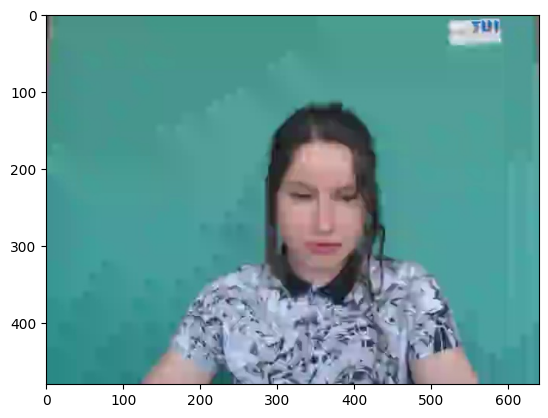

In [12]:
# Copy a frame to the input folder
file_path = os.path.join(output_folder, 'frame_0000.jpg')
!ls -l file_path
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
!mkdir testsets
!mkdir testsets/LIVE1
shutil.move(file_path, 'testsets/LIVE1/frame_0000.jpg')

# 3. Inference


In [22]:
# Run inference using SwinIR transformer model for color JPEG compression artifact reduction
!python SwinIR/main_test_swinir.py --task color_jpeg_car --jpeg 10 --model_path model_zoo/swinir/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth --folder_gt testsets/LIVE1
# Run inference using SwinIR transformer model for color denoising
!python SwinIR/main_test_swinir.py --task color_dn --noise 15 --model_path model_zoo/swinir/005_colorDN_DFWB_s128w8_SwinIR-M_noise15.pth --folder_gt testsets/LIVE1

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
loading model from model_zoo/swinir/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing 0 frame_0000           - PSNR: 33.25 dB; SSIM: 0.9665; PSNRB: 32.86 dB;PSNR_Y: 37.26 dB; SSIM_Y: 0.9789; PSNRB_Y: 36.34 dB.

results/swinir_color_jpeg_car_jpeg10 
-- Average PSNR/SSIM(RGB): 33.25 dB; 0.9665
-- Average PSNR_Y/SSIM_Y: 37.26 dB; 0.9789
-- Average PSNRB: 32.86 dB
-- Average PSNRB_Y: 36.34 dB
/usr/local/l

In [24]:
!ls -l results/swinir_color_jpeg_car_jpeg10
!ls -l results/swinir_color_dn_noise15

total 240
-rw-r--r-- 1 root root 244670 Jul  3 02:19 frame_0000_SwinIR.png
total 280
-rw-r--r-- 1 root root 285384 Jul  3 02:19 frame_0000_SwinIR.png


Original,SwinIR CAR,SwinIR Denoise

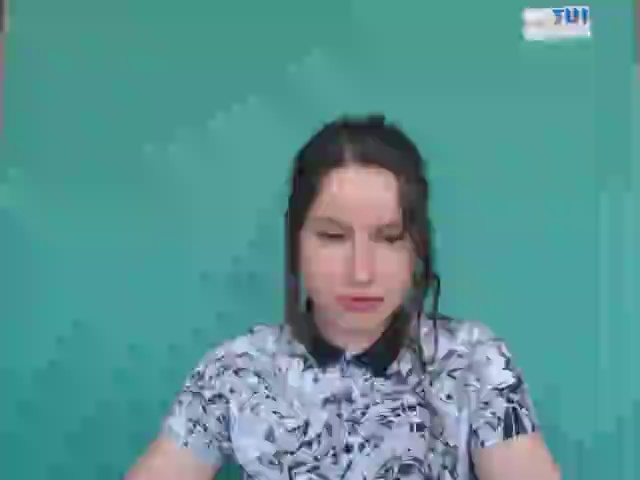
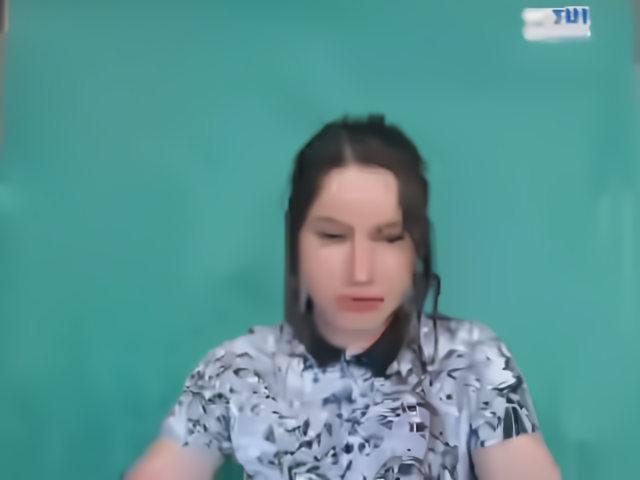
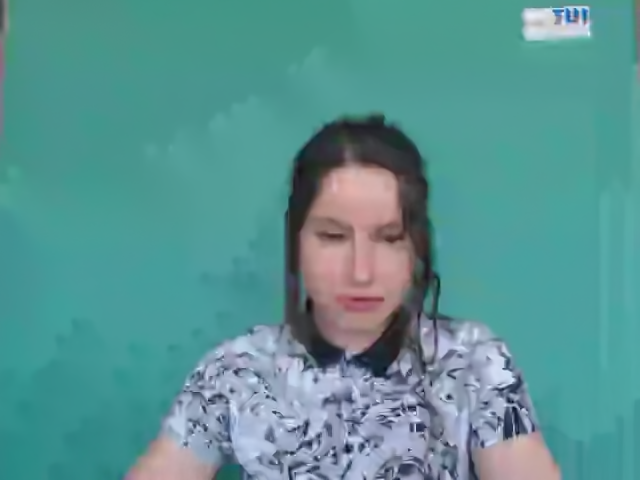

In [25]:
img2 = cv2.imread('results/swinir_color_jpeg_car_jpeg10/frame_0000_SwinIR.png', cv2.IMREAD_UNCHANGED)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#plt.imshow(img2)
img3 = cv2.imread('results/swinir_color_dn_noise15/frame_0000_SwinIR.png', cv2.IMREAD_UNCHANGED)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
images = {'Original': img, 'SwinIR CAR': img2, 'SwinIR Denoise': img3}
media.show_images(images)